# Network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
[Networkx](https://networkx.github.io/documentation/stable/) is a Python module that provides tools for analyzing networks in various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. The [OSMnx](https://github.com/gboeing/osmnx) package enables us to retrieve routable networks from OpenStreetMap for various transport modes (walking, cycling and driving). OSMnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing analysis based on OpenStreetMap data.

Next we will test the routing functionalities of OSMnx by finding a shortest path between two points based on drivable roads. With tiny modifications, it is also possible to repeat the analysis for the walkable street network.

## Get the network

Let's again start by importing the required modules

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx

When fetching netowrk data from OpenStreetMap using OSMnx, it is possible to define the type of street network using the `network_type` parameter (see options from the [OSMnx documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph%20from%20place#osmnx.graph.graph_from_place)).
Let's download the OSM data from Kamppi but this only the bike network. If that does not work, try the driveable network (less roads, faster query..).

In [2]:
#set place name
place_name = 'Kamppi, Helsinki, Finland'

# Retrieve the network
graph = ox.graph_from_place(place_name, network_type='bike')

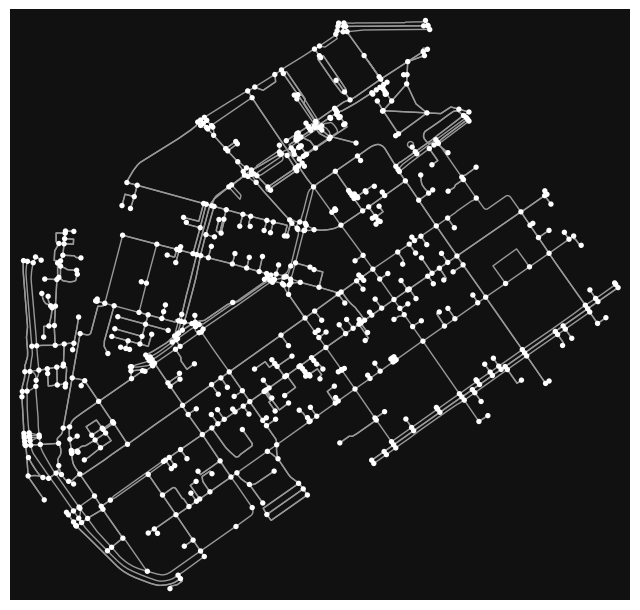

In [3]:
# plot the graph:
fig,ax = ox.plot_graph(graph)

Pro tip! Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Kamppi, in case the shortest path is not completely inside its boundaries. 

In [4]:
# Get the area of interest polygon
place_polygon = ox.geocode_to_gdf(place_name)

# Re-project the polygon to a local projected CRS 
place_polygon = place_polygon.to_crs(epsg=3067)

# Buffer a bit
place_polygon['geometry'] = place_polygon['geometry'].buffer(200)

# Re-project the polygon back to WGS84, as required by osmnx
place_polygon = place_polygon.to_crs(epsg=4326)

# Retrieve the network
graph = ox.graph_from_polygon(place_polygon['geometry'].values[0], network_type='bike')

Plot the graph:

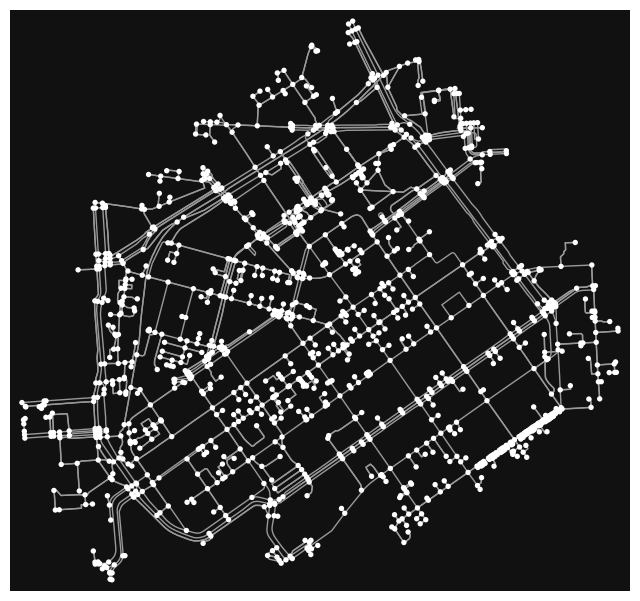

In [5]:
fig, ax = ox.plot_graph(graph)

Okey so now we have streets for the travel mode we specified earlier. Let's have a colser look at the attributes of the street network. Easiest way to do this is to convert the
graph (nodes and edges) into GeoDataFrames.

Converting graph into a GeoDataFrame can be done with function `graph_to_gdfs()` that we already used in previous tutorial. With parameters `nodes` and `edges`, it is possible to control whether to retrieve both nodes and edges from the graph. 

In [6]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [7]:
# Check columns
edges.columns

Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'maxspeed', 'reversed',
       'length', 'geometry', 'junction', 'access', 'bridge', 'tunnel',
       'service', 'width'],
      dtype='object')

In [8]:
# Check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Note that the CRS of the GeoDataFrame is be WGS84 (epsg: 4326).

In [9]:
edges.head()

osmid  oneway lanes             name   
u        v          key                                                       
25216594 1372425721 0               23717777    True     2    Porkkalankatu  \
         1372425714 0               23856784    True     2   Mechelininkatu   
25238865 146447626  0    [59355210, 4229487]   False     2        Santakatu   
         57661989   0                7842621   False   NaN  Sinikaislankuja   
         314767800  0              231643806   False   NaN              NaN   

                             highway maxspeed reversed  length   
u        v          key                                          
25216594 1372425721 0        primary       40    False  10.404  \
         1372425714 0        primary       40    False  40.885   
25238865 146447626  0    residential       30    False  44.303   
         57661989   0    residential       30     True  76.704   
         314767800  0       cycleway      NaN    False  60.066   

                                                                  geometry   
u        v          key                                                      
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)  \
         1372425714 0    LINESTRING (24.92106 60.16479, 24.92095 60.164...   
25238865 146447626  0    LINESTRING (24.91994 60.16279, 24.91932 60.162...   
         57661989   0    LINESTRING (24.91994 60.16279, 24.91995 60.162...   
         314767800  0    LINESTRING (24.91994 60.16279, 24.92014 60.162...   

                        junction access bridge tunnel service width  
u        v          key                                              
25216594 1372425721 0        NaN    NaN    NaN    NaN     NaN   NaN  
         1372425714 0        NaN    NaN    NaN    NaN     NaN   NaN  
25238865 146447626  0        NaN    NaN    NaN    NaN     NaN   NaN  
         57661989   0        NaN    NaN    NaN    NaN     NaN   NaN  
         314767800  0        NaN    NaN    NaN    NaN     NaN   NaN

Okey, so we have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them.
Most of the attributes come directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids. You can click on the links to get more information about each attribute:


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


Let's take a look what kind of features we have in the `highway` column:

In [10]:
edges['highway'].value_counts()

highway
service                      900
residential                  472
cycleway                     467
pedestrian                   394
tertiary                     214
primary                      165
secondary                    121
unclassified                  42
living_street                 16
[pedestrian, service]         14
[living_street, service]       6
[residential, cycleway]        6
[pedestrian, cycleway]         4
[pedestrian, residential]      4
tertiary_link                  2
[residential, service]         2
primary_link                   1
[unclassified, service]        1
Name: count, dtype: int64

I now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways or footways included in the data.

As the data is in WGS84 format, we might want to reproject our data into a metric system before proceeding to the shortest path analysis.
We can re-project the graph from latitudes and longitudes to an appropriate UTM zone using the [project_graph()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function from OSMnx. 

In [11]:
# Project the data
graph_proj = ox.project_graph(graph)

In [12]:
# Get Edges and Nodes
node_proj, edges_proj = ox.graph_to_gdfs(graph_proj)

In [13]:
print(edges_proj.crs)

+proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [14]:
edges_proj.head()

osmid  oneway   
u          v          key                                                    
25216594   1372425721 0                                   23717777    True  \
           1372425714 0                                   23856784    True   
1372425721 25290781   0                                   29191566   False   
           60070671   0          [930820929, 930820930, 654270815]   False   
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]    True   

                            lanes            name   highway maxspeed reversed   
u          v          key                                                       
25216594   1372425721 0         2   Porkkalankatu   primary       40    False  \
           1372425714 0         2  Mechelininkatu   primary       40    False   
1372425721 25290781   0       NaN             NaN  cycleway      NaN     True   
           60070671   0       NaN             NaN  cycleway      NaN    False   
1372425714 25238874   0    [3, 2]  Mechelininkatu   primary       40    False   

                            length   
u          v          key            
25216594   1372425721 0     10.404  \
           1372425714 0     40.885   
1372425721 25290781   0    228.587   
           60070671   0     41.006   
1372425714 25238874   0     85.540   

                                                                    geometry   
u          v          key                                                      
25216594   1372425721 0    LINESTRING (384631.322 6671580.071, 384620.884...  \
           1372425714 0    LINESTRING (384631.322 6671580.071, 384624.750...   
1372425721 25290781   0    LINESTRING (384620.884 6671579.965, 384621.184...   
           60070671   0    LINESTRING (384620.884 6671579.965, 384620.720...   
1372425714 25238874   0    LINESTRING (384624.179 6671539.986, 384623.768...   

                          junction bridge tunnel access service width  
u          v          key                                              
25216594   1372425721 0        NaN    NaN    NaN    NaN     NaN   NaN  
           1372425714 0        NaN    NaN    NaN    NaN     NaN   NaN  
1372425721 25290781   0        NaN    NaN    NaN    NaN     NaN   NaN  
           60070671   0        NaN    NaN    NaN    NaN     NaN   NaN  
1372425714 25238874   0        NaN    NaN    NaN    NaN     NaN   NaN

Okey, as we can see from the CRS the data is now in [UTM projection](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) using zone 35 which is the one used for Finland, and indeed the orientation of the map and the geometry values also confirm this.


Furthermore, we can check the epsg code of this projection using pyproj CRS:

In [15]:
CRS(edges_proj.crs).to_epsg()

32635

Indeed, the projection is now [WGS 84 / UTM zone 35N, EPSG:32635](https://epsg.io/32635).

## Analyzing the network properties

Now as we have seen some of the basic functionalities of OSMnx such as downloading the data and converting data from graph to GeoDataFrame, we can take a look some of the analytical features of omsnx. Osmnx includes many useful functionalities to extract information about the network.

To calculate some of the basic street network measures we can use [basic_stats()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats) function in OSMnx:

In [19]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj)
stats

{'n': 1330,
 'm': 2831,
 'k_avg': 4.257142857142857,
 'edge_length_total': 92305.98399999982,
 'edge_length_avg': 32.605434122218234,
 'streets_per_node_avg': 2.6315789473684212,
 'streets_per_node_counts': {0: 0, 1: 388, 2: 17, 3: 641, 4: 265, 5: 19},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.29172932330827067,
  2: 0.012781954887218045,
  3: 0.48195488721804514,
  4: 0.19924812030075187,
  5: 0.014285714285714285},
 'intersection_count': 942,
 'street_length_total': 57726.74099999985,
 'street_segment_count': 1709,
 'street_length_avg': 33.77808133411343,
 'circuity_avg': 1.0370896909476615,
 'self_loop_proportion': 0.0011702750146284377}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. Let's calculate the area of the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of the street network and see what we can get.



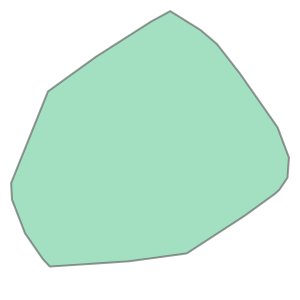

In [20]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Show output
convex_hull

Now we can use the Convex Hull above to calculate [extended statistics for the network](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.extended_stats). As some of the metrics are produced separately for each node, they produce a lot of output. Here, we combine the basic and extended statistics into one pandas Series to keep things in more compact form.

In [65]:
stats = ox.basic_stats(graph, area=convex_hull.area)
stats

{'n': 1330,
 'm': 2831,
 'k_avg': 4.257142857142857,
 'edge_length_total': 92305.98399999987,
 'edge_length_avg': 32.60543412221825,
 'streets_per_node_avg': 2.6315789473684212,
 'streets_per_node_counts': {0: 0, 1: 388, 2: 17, 3: 641, 4: 265, 5: 19},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.29172932330827067,
  2: 0.012781954887218045,
  3: 0.48195488721804514,
  4: 0.19924812030075187,
  5: 0.014285714285714285},
 'intersection_count': 942,
 'street_length_total': 57726.74099999992,
 'street_segment_count': 1709,
 'street_length_avg': 33.77808133411347,
 'circuity_avg': 1.0397616336940356,
 'self_loop_proportion': 0.0011702750146284377,
 'node_density_km': 771.2663015586995,
 'intersection_density_km': 546.2653053145075,
 'edge_density_km': 53528.191647681495,
 'street_density_km': 33475.706791057804}

As we can see, now we have a **LOT** of information about our street network that can be used to understand its structure. We can for example see that the average node density in our network is `149 nodes/km` and that the total edge length of our network is almost 20 kilometers.

Furthermore, we can see that the [degree centrality](https://en.wikipedia.org/wiki/Centrality) of our network is on average `0.0326515`. Degree is a simple centrality measure that counts how many neighbors a node has (here a fraction of nodes it is connected to). Another interesting measure is the [PageRank](https://en.wikipedia.org/wiki/PageRank) that measures the importance of specific node in the graph. Here we can see that the most important node in our graph seem to a node with osmid `25416262`. PageRank was the algorithm that Google first developed (Larry Page & Sergei Brin) to order the search engine results and became famous for.

You can read the [Wikipedia article about different centrality measures](https://en.wikipedia.org/wiki/Centrality) if you are interested what the other centrality measures mean.

## Shortest path analysis

Let's now calculate the shortest path between two points using the [shortest path function in Networkx](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#shortest-path). 

#### Origin and destination points 

First we need to specify the source and target locations for our route. If you are familiar with the Kamppi area, you can specify a custom placename as a source location. Or, you can follow along and choose these points as the origin and destination in the analysis:
- [Maria 01](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01) - and old hospital area and current startup hub.
- [ruttopuisto](https://nominatim.openstreetmap.org/ui/search.html?q=ruttopuisto) - a park. Official name of this park is "Vanha kirkkopuisto", but nominatim is also able to geocode the nickname.

We could figure out the coordinates for these locations manually, and create shapely points based on the coordinates.
However,  it is more handy to fetch the location of our source destination directly from OSM:

In [24]:
# Set place name
placename = 'Maria 01, Helsinki'

In [25]:
# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)

In [26]:
# Check the result
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((24.92122 60.16644, 24.92126 60.16625...",60.167525,60.16624,24.92317,24.921221,110125609,way,23856740,60.166884,24.921661,"Maria 01, 16, Lapinlahdenkatu, Etu-Töölö, Sout...",building,yes,0.58084


As output, we received the building footprint. From here, we can get the centroid as the source location of our shortest path analysis. However, we first need to project the data into the correct crs:

In [27]:
# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(edges_proj.crs)

In [28]:
# Get centroid as shapely point
geocoded_place.crs

<Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
origin = geocoded_place['geometry'].centroid.values[0]
print(origin)

POINT (384692.1787278856 6671817.486583283)


Great! Now we have defined the origin point for our network analysis. 
We can repeat the same steps to retrieve central point of *ruttopuisto*-park as the destination: 

In [30]:
# Set place name
placename_dest = 'ruttopuisto'

# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename_dest)

# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(edges_proj.crs)

# Get centroid of the polygon as shapely point
destination = geocoded_place['geometry'].centroid.values[0]

print(destination)

POINT (385674.0651031759 6671689.576649178)


In [ ]:
'''origin = (
    ox.geocode_to_gdf("Maria 01, Helsinki")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    ox.geocode_to_gdf("ruttopuisto")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)'''

#shorter

Now we have shapely points representing the origin and destination locations for our network analysis. Next step is to find these points on the routable network before the final routing.

#### Nearest node

Let's now find the nearest graph nodes (and their node IDs) to these points using OSMnx [get_nearest_node](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.get_nearest_node). 
As a starting point, we have the two Shapely Point objects we just defined as the origin and destination locations. 

According to the documentation of this function, we need to parse Point coordinates as coordinate-tuples in this order: `latitude, longitude`(or `y, x`). As our data is now projected to UTM projection, we need to specify with `method` parameter that the function uses `'euclidean'` distances to calculate the distance from the point to the closest node (with decimal derees, use `'haversine'`, which determines the great-circle distances). The method parameter is important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter `return_dist=True`.


In [35]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node_id = ox.distance.nearest_nodes(graph_proj, origin.x, origin.y)
orig_node_id

319719983

In [33]:
# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node_id = ox.distance.nearest_nodes(graph_proj, destination.x, destination.y)
target_node_id

2195109761

Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified. 

Let's retrieve the node information from the `nodes_proj` GeoDataFrame by passing the ids to the `loc` indexer

In [36]:
# Retrieve the rows from the nodes GeoDataFrame based on the node id (node id is the index label)
orig_node = node_proj.loc[orig_node_id]
target_node = node_proj.loc[target_node_id]

Let's also create a GeoDataFrame that contains these points

In [37]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=node_proj.crs)
od_nodes.head()

,y,x,street_count,lon,lat,highway,ref,geometry
319719983,6.671816e+06,384706.296089,3,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
2195109761,6.671628e+06,385711.398411,3,24.940478,60.165531,NaN,NaN,POINT (385711.398 6671628.330)


Okay, as a result we got now the closest node IDs of our origin and target locations. As you can see, the `index` in this GeoDataFrame corresponds to the IDs that we found with `get_nearest_node()` function.

#### Routing

Now we are ready to do the routing and find the shortest path between the origin and target locations
by using the `shortest_path()` [function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) of networkx.
With `weight` -parameter we can specify that `'length'` attribute should be used as the cost impedance in the routing. If specifying the weight parameter, NetworkX will use by default Dijkstra's algorithm to find the optimal route. We need to specify the graph that is used for routing, and the origin `ID` (*source*) and the target `ID` in between the shortest path will be calculated:


In [38]:
edges_proj.head() #legth column used for weight

osmid  oneway   
u          v          key                                                    
25216594   1372425721 0                                   23717777    True  \
           1372425714 0                                   23856784    True   
1372425721 25290781   0                                   29191566   False   
           60070671   0          [930820929, 930820930, 654270815]   False   
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]    True   

                            lanes            name   highway maxspeed reversed   
u          v          key                                                       
25216594   1372425721 0         2   Porkkalankatu   primary       40    False  \
           1372425714 0         2  Mechelininkatu   primary       40    False   
1372425721 25290781   0       NaN             NaN  cycleway      NaN     True   
           60070671   0       NaN             NaN  cycleway      NaN    False   
1372425714 25238874   0    [3, 2]  Mechelininkatu   primary       40    False   

                            length   
u          v          key            
25216594   1372425721 0     10.404  \
           1372425714 0     40.885   
1372425721 25290781   0    228.587   
           60070671   0     41.006   
1372425714 25238874   0     85.540   

                                                                    geometry   
u          v          key                                                      
25216594   1372425721 0    LINESTRING (384631.322 6671580.071, 384620.884...  \
           1372425714 0    LINESTRING (384631.322 6671580.071, 384624.750...   
1372425721 25290781   0    LINESTRING (384620.884 6671579.965, 384621.184...   
           60070671   0    LINESTRING (384620.884 6671579.965, 384620.720...   
1372425714 25238874   0    LINESTRING (384624.179 6671539.986, 384623.768...   

                          junction bridge tunnel access service width  
u          v          key                                              
25216594   1372425721 0        NaN    NaN    NaN    NaN     NaN   NaN  
           1372425714 0        NaN    NaN    NaN    NaN     NaN   NaN  
1372425721 25290781   0        NaN    NaN    NaN    NaN     NaN   NaN  
           60070671   0        NaN    NaN    NaN    NaN     NaN   NaN  
1372425714 25238874   0        NaN    NaN    NaN    NaN     NaN   NaN

In [39]:
# Calculate the shortest path
route = nx.shortest_path(graph_proj, source=orig_node_id, target=target_node_id, weight='length')

# Show what we have
print(route)

[319719983, 1382316822, 1382316829, 1382316852, 5464887863, 1382320461, 5154747161, 1378064352, 1372461709, 1372441203, 3205236795, 3205236793, 8244768393, 60278325, 56115897, 60072524, 7699019923, 7699019916, 7699019908, 7699019903, 267117319, 1897461604, 724233143, 724233128, 267117317, 846597945, 846597947, 2037356632, 1547012339, 569742461, 1372441189, 4524927399, 298372061, 7702074840, 7702074833, 60170471, 8856704555, 3227176325, 7676757030, 8856704573, 7676756995, 8856704588, 1377211668, 7676890497, 1377211666, 292859324, 25291565, 2195109761]


As a result we get a list of all the nodes that are along the shortest path. 

- We could extract the locations of those nodes from the `nodes_proj` GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using `plot_graph_route()` function:


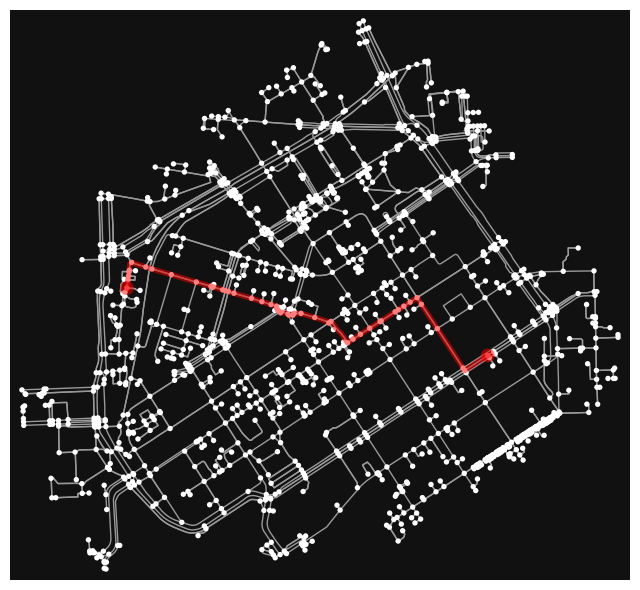

In [40]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route=route)

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable information for many applications.
Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the
optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

## Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a linestring and save the shortest path geometry and related attributes into a geopackage file.

- First we need to get the nodes that belong to the shortest path:


In [50]:
# Get the nodes along the shortest path
route_nodes = node_proj.loc[route]
route_nodes

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
319719983,6.671816e+06,384706.296089,3,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
1382316822,6.671839e+06,384709.579017,4,24.922319,60.167142,NaN,NaN,POINT (384709.579 6671839.311)
1382316829,6.671850e+06,384711.044607,3,24.922339,60.167236,NaN,NaN,POINT (384711.045 6671849.707)
1382316852,6.671861e+06,384712.504583,3,24.922359,60.167338,NaN,NaN,POINT (384712.505 6671860.984)
5464887863,6.671865e+06,384713.220293,3,24.922370,60.167377,NaN,NaN,POINT (384713.220 6671865.374)
1382320461,6.671887e+06,384719.671826,3,24.922473,60.167575,NaN,NaN,POINT (384719.672 6671887.215)
5154747161,6.671874e+06,384758.946564,3,24.923188,60.167471,NaN,NaN,POINT (384758.947 6671874.411)
1378064352,6.671869e+06,384776.322613,3,24.923504,60.167428,NaN,NaN,POINT (384776.323 6671869.117)
1372461709,6.671853e+06,384830.142058,3,24.924482,60.167300,NaN,NaN,POINT (384830.142 6671853.149)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

- Now we can create a LineString out of the Point geometries of the nodes:

In [42]:
from shapely.geometry import LineString, Point

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes['geometry'].values))

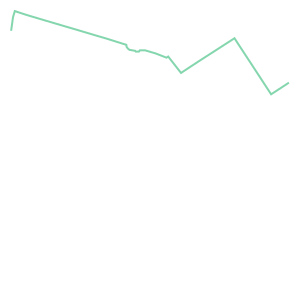

In [43]:
route_line

In [44]:
print(route_line)

LINESTRING (384706.29608871765 6671815.98858631, 384709.579016634 6671839.310766771, 384711.0446067815 6671849.706932714, 384712.5045834767 6671860.9836821705, 384713.2202930655 6671865.3743352685, 384719.6718256475 6671887.2149038445, 384758.9465637259 6671874.411331248, 384776.32261348976 6671869.117258262, 384830.1420579157 6671853.148941502, 384899.781649031 6671832.538648067, 384940.40418043704 6671820.7088605175, 384945.2567720086 6671819.263710763, 384946.3350484787 6671818.94009317, 384973.26532807044 6671810.884028205, 384980.95199481817 6671808.6144153, 384989.08489757683 6671806.2305105785, 385004.61911968584 6671801.508009418, 385053.4383533402 6671787.182207731, 385082.4555245211 6671778.013918371, 385107.86520534346 6671769.973132519, 385122.9978634067 6671765.364038103, 385124.3280759595 6671757.666171253, 385129.2421867896 6671751.271259709, 385134.4591417715 6671747.095726167, 385154.9584002629 6671743.611252417, 385157.55633551866 6671740.743731404, 385168.6664254228 

Now we have the route as a LineString geometry. 

- Let's make a GeoDataFrame out of it having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [51]:
#remove osmid column as index
route_nodes = route_nodes.reset_index()
route_nodes.head()


,osmid,y,x,street_count,lon,lat,highway,ref,geometry
0,319719983,6.671816e+06,384706.296089,3,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
1,1382316822,6.671839e+06,384709.579017,4,24.922319,60.167142,NaN,NaN,POINT (384709.579 6671839.311)
2,1382316829,6.671850e+06,384711.044607,3,24.922339,60.167236,NaN,NaN,POINT (384711.045 6671849.707)
3,1382316852,6.671861e+06,384712.504583,3,24.922359,60.167338,NaN,NaN,POINT (384712.505 6671860.984)
4,5464887863,6.671865e+06,384713.220293,3,24.922370,60.167377,NaN,NaN,POINT (384713.220 6671865.374)


In [52]:
# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Add a list of osmids associated with the route
route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

# Calculate the route length
route_geom['length_m'] = route_geom.length

route_geom.head()

,geometry,osmids,length_m
0,"LINESTRING (384706.296 6671815.989, 384709.579...","[319719983, 1382316822, 1382316829, 1382316852...",1291.324588


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that everything is ok by plotting our route on top of our street network and some buildings, and plot also the origin and target points on top of our map.

- Get buildings:

In [53]:
tags = {'building': True}
buildings = ox.geometries_from_place(place_name, tags)

'''buildings = osmnx.geometries_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)'''
#alternaive

re-project buildings

In [54]:
buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

- Let's now plot the route and the street network elements to verify that everything is as it should:

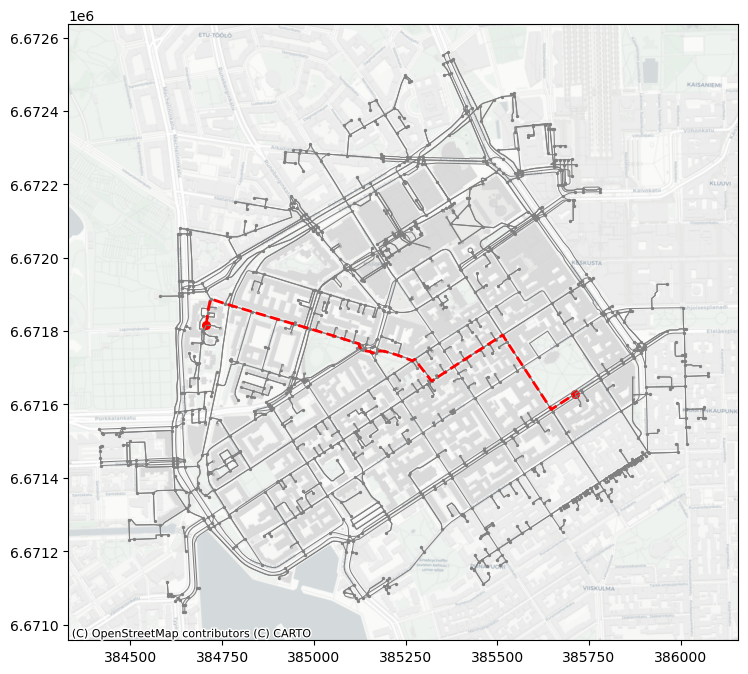

In [56]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot edges and nodes
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
node_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=30, color='red')

# Add basemap
ctx.add_basemap(ax, crs=buildings_proj.crs, source=ctx.providers.CartoDB.Positron)


Great everything seems to be in order! As you can see, now we have a full control of all the elements of our map and we can use all the aesthetic properties that matplotlib provides to modify how our map will look like. Now we are almost ready to save our data into disk.


## Prepare data for saving to file

The data contain certain data types (such as `list` or `boolean`) that should be converted into character strings prior to saving the data to file.Another option would be to drop invalid columns.

In [57]:
edges_proj.head()

osmid  oneway   
u          v          key                                                    
25216594   1372425721 0                                   23717777    True  \
           1372425714 0                                   23856784    True   
1372425721 25290781   0                                   29191566   False   
           60070671   0          [930820929, 930820930, 654270815]   False   
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]    True   

                            lanes            name   highway maxspeed reversed   
u          v          key                                                       
25216594   1372425721 0         2   Porkkalankatu   primary       40    False  \
           1372425714 0         2  Mechelininkatu   primary       40    False   
1372425721 25290781   0       NaN             NaN  cycleway      NaN     True   
           60070671   0       NaN             NaN  cycleway      NaN    False   
1372425714 25238874   0    [3, 2]  Mechelininkatu   primary       40    False   

                            length   
u          v          key            
25216594   1372425721 0     10.404  \
           1372425714 0     40.885   
1372425721 25290781   0    228.587   
           60070671   0     41.006   
1372425714 25238874   0     85.540   

                                                                    geometry   
u          v          key                                                      
25216594   1372425721 0    LINESTRING (384631.322 6671580.071, 384620.884...  \
           1372425714 0    LINESTRING (384631.322 6671580.071, 384624.750...   
1372425721 25290781   0    LINESTRING (384620.884 6671579.965, 384621.184...   
           60070671   0    LINESTRING (384620.884 6671579.965, 384620.720...   
1372425714 25238874   0    LINESTRING (384624.179 6671539.986, 384623.768...   

                          junction bridge tunnel access service width  
u          v          key                                              
25216594   1372425721 0        NaN    NaN    NaN    NaN     NaN   NaN  
           1372425714 0        NaN    NaN    NaN    NaN     NaN   NaN  
1372425721 25290781   0        NaN    NaN    NaN    NaN     NaN   NaN  
           60070671   0        NaN    NaN    NaN    NaN     NaN   NaN  
1372425714 25238874   0        NaN    NaN    NaN    NaN     NaN   NaN

In [59]:
# Columns with invalid values
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid', "highway", "service"]

#  convert selected columns to string format
edges_proj[invalid_cols] = edges_proj[invalid_cols].astype(str)

In [67]:
route_geom.head()

,geometry,osmids,length_m
0,"LINESTRING (384706.296 6671815.989, 384709.579...","[319719983, 1382316822, 1382316829, 1382316852...",1291.324588


In [68]:
route_geom["osmids"] = route_geom["osmids"].astype(str)

Now we can see that most of the attributes are of type `object` that quite often (such as ours here) refers to a string type of data.

## Save the data:

In [73]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [74]:
# Save one layer after another
output_gpkg = DATA_DIRECTORY / "OSM_Kamppi.gpkg"

edges_proj.to_file(output_gpkg, layer="streets")
route_geom.to_file(output_gpkg, layer="route")
node_proj.to_file(output_gpkg, layer="nodes")
buildings[['geometry', 'name', 'addr:street']].to_file(output_gpkg, layer="buildings")

ValueError: Invalid field type <class 'list'>

In [72]:
import os

# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

# Output directory
out_dir = "data"

# Create output fp for a geopackage
out_fp = os.path.join(out_dir, f"OSM_{place_name_out}.gpkg")

# Save files
edges_proj.to_file(out_fp, layer="streets", driver="GPKG")
route_geom.to_file(out_fp, layer="route", driver="GPKG")
node_proj.to_file(out_fp, layer="nodes", driver="GPKG")
od_nodes.to_file(out_fp, layer="route_OD", driver="GPKG")
buildings[['geometry', 'name', 'addr:street']].to_file(out_fp, layer="buildings", driver="GPKG")


ValueError: Invalid field type <class 'list'>

Great, now we have saved all the data that was used to produce the maps into a geopackage.

## Advanced reading

Here we learned how to solve a simple routing task between origin and destination points. What about if we have hundreads or thousands of origins? This is the case if you want to explore the travel distances to a spesific location across the whole city, for example, when analyzing the accessibility of jobs and services (like in the Travel Time Matrix dataset used in previous sections). 

Check out pyrosm documentation on [working with graphs](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs) for more advanced examples of network analysis in python. For example, [pandana](https://udst.github.io/pandana/) is a fast and efficient python library for creating aggretated network analysis in no time across large networks, and pyrosm can be used for preparing the input data for such analysis. 